In [1]:
%pylab
# Import functions and libraries
import numpy as np
import matplotlib.pyplot as plt
import pyaudio
import Queue
import threading,time
import sys

from numpy import pi
from numpy import sin
from numpy import zeros
from numpy import r_
from numpy import ones
from scipy import signal
from scipy import integrate
from __future__ import division

import threading,time
import multiprocessing

from rtlsdr import RtlSdr, limit_time
from numpy import mean
from numpy import power
from numpy.fft import fft
from numpy.fft import fftshift
from numpy.fft import ifft
from numpy.fft import ifftshift
import bitarray
from  scipy.io.wavfile import read as wavread
import serial

%matplotlib inline

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
from radio import *
from encoding import *
import util

In [3]:
x = compressandencode('bird.jpg')

Found image with width 700 and height 700
Finished transform to Y, Cb, Cr
Got coefficients
Compressed to 94984 bits


In [4]:
# decompressanddecode(x)

In [5]:
fs = 44100  # sampling rate
Ns = 20 # samples per bit
baud = float(fs)/Ns  # symbol rate
print(baud)

f_low = 1102.5
f_high = 2205

Nbits_packet_noec = 4800
wait_len = 160

Nbits_packet = len(util.encorrect(np.zeros(Nbits_packet_noec)))

between_len = wait_len * 2

msg_len = Ns * Nbits_packet

pulse = genChirpPulse(1600, 500.0, 3500.0, 44100.0)
pulse = pulse.real / 2.0

2205.0


In [6]:
ar = np.array(x.tolist())
bit_list = []
for i in xrange(0, len(ar), Nbits_packet_noec):
    b = ar[i:i+Nbits_packet_noec]
    if len(b) < Nbits_packet_noec:
        b = np.append(b, np.zeros(Nbits_packet_noec - len(b)))
    bit_list.append(util.encorrect(b))
    
N_packets = len(bit_list)
N_packets

20

In [7]:
def build_packet(bits):
    msg = afsk(1.0 * bits, f_low, f_high, baud, fs)
    return np.hstack([pulse, np.zeros(wait_len), msg])

def findPackets(sig, fs_down=fs):
    pulse_re = signal.resample(pulse, len(pulse) * float(fs_down) / float(fs))
    corr = abs(crossCorr(sig, pulse_re))
    thres = np.median(corr) * 7
    
    packets = []
    
    wait_len_adj = wait_len * float(fs_down) / float(fs)
    msg_len_adj = msg_len * float(fs_down) / float(fs)
    
    packet_len_adj = len(pulse_re) + wait_len_adj + msg_len_adj 
    
    ps = []
    
    for i in range(0, len(corr), int(packet_len_adj)):
        c = corr[i:i+packet_len_adj]
        if sum(c > thres) > 0:
            ps.append(np.argmax(c) + i)
    
    #ps = np.where(corr > thres)[0]
    
    last_flag = -1
    
    for p in ps:
        start, end = int(p + wait_len_adj), int(p + msg_len_adj + wait_len_adj)
        
        if end >= len(sig):
            last_flag = start - len(pulse_re) - wait_len_adj - 100
            break
        else:
            packets.append(sig[start:end])
    
    return packets, last_flag

def decodePacket(pp, fs_down=fs):
    demod = nc_afsk_demod(pp, f_low, f_high, TBW=1.5, fs=fs_down)
    #demod = demod - np.mean(demod)
    decoded = decode_bits2(np.sign(demod), fs=fs_down, baud=baud)
    return decoded

def get_packets(sig, fs_down=fs):
    sigs = findPackets(sig, fs_down)
    decodes = [decodePacket(s, fs_down) for s in sigs]
    return decodes
    

In [9]:
def demodulate(sdr_samples, sample_rate, ignore=0):
    t = np.arange(len(sdr_samples)) / sample_rate
    demod = np.exp(-2j*pi*freq_offset*t)
    y = sdr_samples * demod

    threshold = 0.04
    y = y[abs(y) > threshold]

    from scipy import signal  #should be imported already?

    sig = angle(y[1:] * conj(y[:-1]))

    h = signal.firwin(256,4000.0,nyq=sample_rate/2.0)
    sigf = signal.fftconvolve(sig, h)
    if ignore > 0:
        sigf = sigf[ignore:-ignore]
    
    
    downsample = 30
    sigfd = sigf[::downsample]

    fs_down = fs
    sigfdd = signal.resample(sigfd, len(sigfd) * float(fs_down) / (sample_rate / float(downsample)))
    
    return sigfdd

def smart_demod(sdr_samples, sample_rate, chunk_len = 10240):
    t = np.arange(len(sdr_samples)) / sample_rate
    demod = np.exp(-2j*pi*freq_offset*t)
    y = sdr_samples * demod

    threshold = np.min(abs(y))*1.01
    if sum(abs(y) < threshold)/float(len(y)) < 0.3:
        y = y[abs(y) > threshold]

    from scipy import signal  #should be imported already?

    sig = angle(y[1:] * conj(y[:-1]))

    h = signal.firwin(256,4000.0,nyq=sample_rate/2.0)
    sigf = signal.fftconvolve(sig, h)
    
    downsample = 30
    sigfd = sigf[::downsample]
    
    result = np.array([])
    pad = 1024
    
    scale = float(fs) / (sample_rate / float(downsample))
    
    out = []
        
    for i in xrange(pad, len(sigfd), chunk_len):
        s = sigfd[i:i+chunk_len]
        r = signal.resample(s, len(s) * scale)
        out.append(r)
    
    return np.hstack(out)
        

In [10]:
def printDevNumbers(p):
    N = p.get_device_count()
    for n in range(0,N):
        name = p.get_device_info_by_index(n).get('name')
        print n, name
        
p = pyaudio.PyAudio()
printDevNumbers(p)
p.terminate()

0 HDA NVidia: CS4206 Analog (hw:0,0)
1 HDA NVidia: CS4206 Digital (hw:0,1)
2 HDA NVidia: HDMI 0 (hw:0,3)
3 HDA NVidia: HDMI 0 (hw:0,7)
4 HDA NVidia: HDMI 0 (hw:0,8)
5 USB PnP Sound Device: Audio (hw:1,0)
6 sysdefault
7 front
8 surround21
9 surround40
10 surround51
11 surround71
12 iec958
13 spdif
14 hdmi
15 pulse
16 dmixout
17 dmix
18 default


In [11]:
# CHANGE!!!!
dusb_in = 5
dusb_out = 5
din = 0
dout = 0

In [22]:
if sys.platform == 'darwin':  # Mac
    s = serial.Serial(port='/dev/tty.SLAB_USBtoUART')
else:                         #windows
    s = serial.Serial(port='/dev/ttyUSB0') ##### CHANGE !!!!!!
s.setDTR(0)

In [13]:
try:
    sdr = RtlSdr()
except IOError:
    print('defined already')

In [14]:
#sdr.close()

In [15]:
zero_sample = np.zeros(int(44100 * 0.3))

packet = build_packet(bit_list[0])

record_len = int(((len(packet) + between_len) / float(fs))*N_packets) + 1
if record_len % 2 != 0:
    record_len += 1

In [16]:
record_len

46

In [17]:
freq_offset = 83.2e3

sample_rate = 240e3
center_freq = 443.582e6 - freq_offset
#center_freq = 145.442e6 #- freq_offset

sdr.sample_rate = sample_rate  
sdr.center_freq = center_freq   
sdr.gain = 2

In [23]:
# creates a queue
Qout = Queue.Queue()

# initialize a serial port 
s.setDTR(0)
# create a pyaudio object
p = pyaudio.PyAudio()

t_play = threading.Thread(target = play_audio,   args = (Qout,   p, 44100, dusb_out, s ,0.2 ))

#Qout.put(sig2)
Qout.put("KEYON")
Qout.put(zero_sample)

for i in range(N_packets):
    Qout.put(build_packet(bit_list[i]))
    Qout.put(np.zeros(between_len))

Qout.put(np.zeros(1024))
Qout.put("KEYOFF")
Qout.put(zero_sample)
Qout.put("EOT")

# play audio from Queue 
t_play.start()

samples = []

def callback(ss, obj):
    samples.append(ss)
    #obj.cancel_read_async()

N_samples = sample_rate*0.5 # approximately seconds
sdr.read_samples_async(limit_time(record_len)(callback), N_samples)   # get samples

sdr_samples = np.hstack(samples)
    
# must wait for the queue to empty before terminating pyaudio
while not(Qout.empty()) :
    time.sleep(1)
    

p.terminate()# kill a playing thread

IOError: Error code -2 when requesting 240000 bytes

In [19]:
# _ = myspectrogram_hann_ovlp(sdr_samples, 2048, sample_rate, center_freq)

Exception in thread Thread-3:
Traceback (most recent call last):
  File "/usr/lib/python2.7/threading.py", line 810, in __bootstrap_inner
    self.run()
  File "/usr/lib/python2.7/threading.py", line 763, in run
    self.__target(*self.__args, **self.__kwargs)
  File "radio.py", line 125, in play_audio
    ser.setDTR(0)
  File "/usr/lib/python2.7/site-packages/serial/serialposix.py", line 564, in setDTR
    fcntl.ioctl(self.fd, TIOCMBIC, TIOCM_DTR_str)
IOError: [Errno 5] Input/output error



In [20]:
ss = smart_demod(sdr_samples, sample_rate)

NameError: name 'sdr_samples' is not defined

1


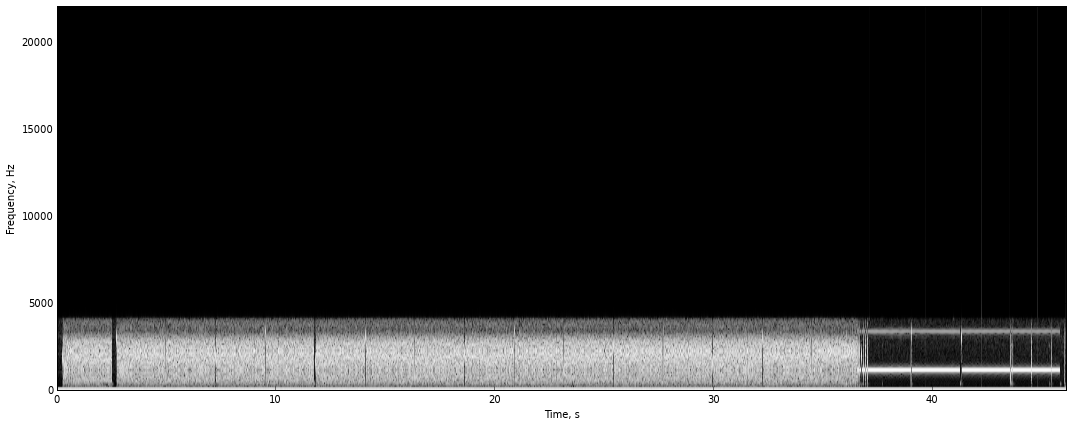

In [82]:
figure()
wsize = 512
dbf = 20
_ = myspectrogram_hann_ovlp(ss, wsize, fs, 0, dbf)

In [84]:
import Levenshtein as leven

packets = findPackets(ss)[0]
print(len(packets))

print('errors')
for i in range(len(packets)):
    pp = packets[i]
    decoded = decodePacket(pp)

    ds = ''.join([str(int(x)) for x in decoded])
    bs = ''.join([str(int(x)) for x in bit_list[i]])

    dist = leven.distance(bs, ds)
    print(dist)
#     print(100 * float(dist) / Nbits)
    print(leven.editops(bs, ds)[:10])

20
errors
0
[]
0
[]
0
[]
1
[('replace', 0, 0)]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
1
[('replace', 0, 0)]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]


In [85]:
decodes = map(lambda p: util.correct(decodePacket(p)), packets)

In [86]:
new_x = np.hstack(decodes)
new_x_bits = bitarray.bitarray(new_x[:len(ar)].tolist())

In [87]:
len(new_x_bits)

94984

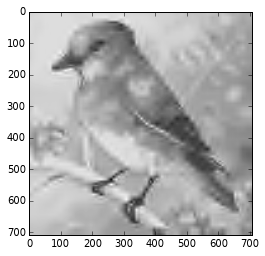

In [88]:
decompressanddecode(new_x_bits)